In [1]:
import numpy as np
import json
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
translator = str.maketrans('', '', string.punctuation)
import dynet as dy
import random

In [2]:
"'adasd;'".translate(translator)

'adasd'

In [3]:
x_train = json.load(open('train.json'))

In [4]:
x_train[:1]

[{'identifier': 'train-A9164',
  'initial_env': '1:ggg 2:_ 3:_ 4:_ 5:o 6:ooo 7:gggg',
  'utterances': [{'actions': ['pop 1', 'pop 1'],
    'after_env': '1:g 2:_ 3:_ 4:_ 5:o 6:ooo 7:gggg',
    'instruction': 'throw out two units of first beaker'},
   {'actions': ['pop 5'],
    'after_env': '1:g 2:_ 3:_ 4:_ 5:_ 6:ooo 7:gggg',
    'instruction': 'throw out fifth beaker'},
   {'actions': ['pop 1'],
    'after_env': '1:_ 2:_ 3:_ 4:_ 5:_ 6:ooo 7:gggg',
    'instruction': 'throw out first one'},
   {'actions': ['pop 6', 'pop 6', 'pop 6'],
    'after_env': '1:_ 2:_ 3:_ 4:_ 5:_ 6:_ 7:gggg',
    'instruction': 'throw out orange beaker'},
   {'actions': ['pop 7'],
    'after_env': '1:_ 2:_ 3:_ 4:_ 5:_ 6:_ 7:ggg',
    'instruction': 'throw out one unit of green'}]}]

In [5]:
ins_exp = [[step['instruction'].translate(translator) for step in exp['utterances']] for exp in x_train]

In [6]:
act_exp = [[step['actions'] for step in exp['utterances']] for exp in x_train]

In [7]:
ins_exp[1]

['throw out one unit of last beaker',
 'throw out three units of third one',
 'pour fourth beaker into it',
 'it turns brown',
 'throw out one unit of it']

In [8]:
act_exp[1]

[['pop 7'],
 ['pop 3', 'pop 3', 'pop 3'],
 ['push 3 o', 'pop 4'],
 ['pop 3', 'pop 3', 'push 3 b', 'push 3 b'],
 ['pop 3']]

In [9]:
%%time
ins = [j.replace("'",'') for i in ins_exp for j in i]
act = [(['<start>']+j+['<end>']) for i in act_exp for j in i]

CPU times: user 45.8 ms, sys: 7.34 ms, total: 53.1 ms
Wall time: 58.2 ms


In [10]:
ins[6]

'throw out three units of third one'

In [11]:
act[:2]

[['<start>', 'pop 1', 'pop 1', '<end>'], ['<start>', 'pop 5', '<end>']]

In [12]:
words_ins = [word for sentence in ins for word in (sentence.split())]

In [13]:
words_act = [word for sentence in act for word in (sentence)]

In [14]:
act_counter = Counter(words_act)
ins_counter = Counter(words_ins)

In [15]:
ins[1]

'throw out fifth beaker'

In [16]:
len(ins_counter.keys())

610

/Users/Work/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


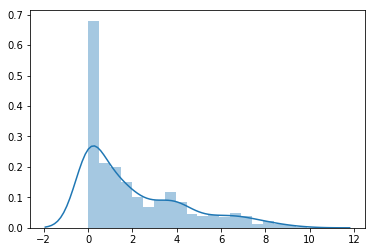

In [17]:
sns.distplot(np.log(list(ins_counter.values())),bins=20)

In [18]:
words_ins_cor = [x if ins_counter[x]>=3 else '<unknown>' for x in words_ins]

In [19]:
len(Counter(words_ins_cor))

342

In [20]:
vocab_set = set(words_ins_cor)
vocab = sorted(vocab_set)
vocab_dic = {}
for i, word in enumerate(vocab):
    vocab_dic[word]=i

In [21]:
vocab_out = sorted(set(words_act))

In [22]:
len(vocab_out)

51

## Dynet

In [23]:
LAYERS = 1
INPUT_DIM = 50
HIDDEN_DIM = 100
VOCAB_SIZE_input = len(vocab)
VOCAB_SIZE_out= len(vocab_out)

In [24]:
pc = dy.ParameterCollection()
encoder = dy.LSTMBuilder(LAYERS, INPUT_DIM, HIDDEN_DIM, pc)
decoder = dy.LSTMBuilder(LAYERS, INPUT_DIM+HIDDEN_DIM, HIDDEN_DIM, pc)
params_encoder={}
params_encoder["lookup"] = pc.add_lookup_parameters((VOCAB_SIZE_input, INPUT_DIM))
params_decoder= {}
params_decoder["lookup"] = pc.add_lookup_parameters((VOCAB_SIZE_out, INPUT_DIM))
params_decoder["R"] = pc.add_parameters((VOCAB_SIZE_out, HIDDEN_DIM))
params_decoder["bias"] = pc.add_parameters((VOCAB_SIZE_out))

In [25]:
def do_one_sentence(encoder,decoder, params_encoder,params_decoder, sentence,output):
    # setup the sentence
    dy.renew_cg()
    s0 = encoder.initial_state()
    lookup = params_encoder["lookup"]
    sentence = sentence.split()
    sentence = [vocab.index(c) if c in vocab else vocab.index('<unknown>') for c in sentence]
    s = s0
    loss = []
    generate = []
    for word in (sentence):
        s = s.add_input(lookup[word])
    encode_output = s.output()
    
    _s0 = decoder.initial_state()
    _s = _s0
    R = params_decoder["R"]
    bias = params_decoder["bias"]
    index=1
    input_word = "<start>"
    _lookup = params_decoder["lookup"]
    while True:
        #print(output[index])
        word = vocab_out.index(input_word)
        gt_y = vocab_out.index(output[index])
        #print((dy.concatenate([_lookup[word],encode_output])).npvalue().shape
        #     )
        _s = _s.add_input(dy.concatenate([_lookup[word],encode_output]))
        #print((np.array(_s.output().value()).dot(R.as_array().T )).shape)
        probs = dy.softmax((R) * _s.output() + bias)
        prediction = np.argmax(probs.value())
        generate.append(vocab_out[prediction])
        loss.append( -dy.log(dy.pick(probs,gt_y)) )
        if output[index] == '<end>':
            break
        index+=1
        input_word = vocab_out[prediction]

    loss = dy.esum(loss)
    return loss,generate

In [26]:
for i in range(10):    
    print('Epoch%d' % i)
    count=0
    sum=0
    for sentence, output in zip(ins,act):
        count+=1
        trainer = dy.SimpleSGDTrainer(pc)
        loss,generate = do_one_sentence(encoder,decoder, params_encoder,params_decoder, sentence,output)
        loss_value = loss.value()
        loss.backward()
        trainer.update()
        sum+=loss_value
        if count % 2000 == 0:
            print("%.10f" % (sum/2000), end="\t")
            sum=0
        if count==1 or (count==6) or (count==7) :
            print(sentence,output,generate)

        #print(generate(rnn, params))

Epoch0
throw out two units of first beaker ['<start>', 'pop 1', 'pop 1', '<end>'] ['pop 7', '<end>', '<end>']
throw out one unit of last beaker ['<start>', 'pop 7', '<end>'] ['<end>', '<end>']
throw out three units of third one ['<start>', 'pop 3', 'pop 3', 'pop 3', '<end>'] ['<end>', '<end>', '<end>', '<end>']
7.4870231373	6.6923611988	6.5617515441	6.3022048811	6.1328391033	6.0957018544	5.8106522924	5.6429601336	5.3718946125	Epoch1
throw out two units of first beaker ['<start>', 'pop 1', 'pop 1', '<end>'] ['pop 1', 'pop 1', '<end>']
throw out one unit of last beaker ['<start>', 'pop 7', '<end>'] ['pop 7', '<end>']
throw out three units of third one ['<start>', 'pop 3', 'pop 3', 'pop 3', '<end>'] ['pop 3', 'pop 3', 'pop 3', '<end>']
5.1013986261	5.5540914090	5.1907015629	5.0097754532	4.9991333253	5.1530043918	4.9308429158	4.9517879990	

KeyboardInterrupt: 

### Scrach for DyNet

In [ ]:
a=dy.inputTensor([0.1,0.4,0.5])

In [ ]:
dy.pick(a).value()

In [ ]:
np.argmax([0.1,0.2,0.3])

In [ ]:
    def sample(probs):
        rnd = random.random()
        for i,p in enumerate(probs):
            rnd -= p
            if rnd <= 0: break
        return i

In [158]:
sample([0.1,0.2,0.3])

2

In [131]:
rnd = random.random()

In [126]:
rnd

0.8238484676667333

In [174]:
dy.softmax(a).value()

[0.2603025436401367, 0.351371705532074, 0.3883257806301117]

In [268]:
a.dim()

((3,), 1)